# Introduction to Fraud Detection Systems

Fraud detection is one of the top priorities for banks and financial institutions, which can be addressed using machine learning. According to [a report published by Nilson](https://nilsonreport.com/upload/content_promo/The_Nilson_Report_Issue_1118.pdf), in 2017 the worldwide losses in card fraud related cases reached 22.8 billion dollars. The problem is forecasted to get worse in the following years, by 2021, the card fraud bill is expected to be 32.96 billion dollars.

In this tutorial, we will use the [credit card fraud detection dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) from Kaggle, to identify fraud cases. We will use a [gradient boosted tree](https://blogs.technet.microsoft.com/machinelearning/2017/07/25/lessons-learned-benchmarking-fast-machine-learning-algorithms/) as a machine learning algorithm. And finally, we will create a simple API to operationalize (o16n) the model.

We will use the gradient boosting library [LightGBM](https://github.com/Microsoft/LightGBM), which has recently became one of the most popular libraries for top participants in [Kaggle competitions](https://github.com/Microsoft/LightGBM/tree/a39c848e6456d473d2043dff3f5159945a36b567/examples). 

Fraud detection problems are known for being extremely imbalanced. <a href="https://en.wikipedia.org/wiki/Boosting_(machine_learning)">Boosting</a> is one technique that usually works well with these kind of datasets. It iteratively creates weak classifiers (decision trees) weighting the instances to increase the performance. In the first subset, a weak classifier is trained and tested on all the training data, those instances that have bad performance are weighted to appear more in the next data subset. Finally, all the classifiers are ensembled with a weighted average of their estimates.

In LightGBM, there is a [parameter](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst#objective-parameters) called `is_unbalanced` that automatically helps you to control this issue. 

LigtGBM can be used with or without [GPU](https://lightgbm.readthedocs.io/en/latest/GPU-Performance.html). For small datasets, like the one we are using here, it is faster to use CPU, due to IO overhead. However, I wanted to showcase the GPU alternative, which is trickier to install, in case anyone wants to experiment with bigger datasets.

To install the dependencies in Linux:
```bash
$ sudo apt-get update
$ sudo apt-get install cmake build-essential libboost-all-dev -y
$ conda env create -n fraud -f conda.yaml
$ source activate fraud
(fraud)$ python -m ipykernel install --user --name fraud --display-name "Python (fraud)"
```

In [1]:
import numpy as np
import sys
import os
import json
import pandas as pd
from collections import Counter
import requests
from IPython.core.display import display, HTML
import lightgbm as lgb
import sklearn
import aiohttp
import asyncio
from utils import (split_train_test, classification_metrics_binary, classification_metrics_binary_prob,
                   binarize_prediction, plot_confusion_matrix, run_load_test, read_from_sqlite)
from utils import BASELINE_MODEL, PORT, TABLE_FRAUD, TABLE_LOCATIONS, DATABASE_FILE

print("System version: {}".format(sys.version))
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("LightGBM version: {}".format(lgb.__version__))
print("Sklearn version: {}".format(sklearn.__version__))

%load_ext autoreload
%autoreload 2

/tmp/ipykernel_13047/3328349244.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


System version: 3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0]
Numpy version: 1.21.6
Pandas version: 1.4.2
LightGBM version: 3.3.3
Sklearn version: 1.0.2


## Dataset
The first step is to load the dataset and analyze it.

For it, before continuing, **you have to run the notebook [data_prep.ipynb](data_prep.ipynb)**, which will generate the SQLite database.

In [2]:
query = 'SELECT * FROM ' + TABLE_FRAUD
df = read_from_sqlite(DATABASE_FILE, query)

In [3]:
print("Shape: {}".format(df.shape))
df.head()

Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As we can see, the dataset is extremely imbalanced. The minority class counts for around 0.002% of the examples.

In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

The next step is to split the dataset into train and test.

In [6]:
X_train, X_test, y_train, y_test = split_train_test(df.drop('Class', axis=1), df['Class'], test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227845, 30)
(56962, 30)
(227845,)
(56962,)


In [7]:
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

0    227451
1       394
Name: Class, dtype: int64
0    0.998271
1    0.001729
Name: Class, dtype: float64
0    56864
1       98
Name: Class, dtype: int64
0    0.99828
1    0.00172
Name: Class, dtype: float64


## Training with LightGBM - Baseline 

For this task we use a simple set of parameters to train the model. We just want to create a baseline model, so we are not performing here cross validation or parameter tunning. 

The details of the different parameters of LightGBM can be found in the [documentation](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst). Also, the authors provide [some advices](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters-Tuning.rst) on how to tune the parameters and prevent overfitting.

In [8]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)

In [9]:
parameters = {'num_leaves': 2**8,
              'learning_rate': 0.1,
              'is_unbalance': True,
              'min_split_gain': 0.1,
              'min_child_weight': 1,
              'reg_lambda': 1,
              'subsample': 1,
              'objective':'binary',
              #'device': 'gpu', # comment this line if you are not using GPU
              'task': 'train',
              'verbose':-1
              }
num_rounds = 300

In [10]:
%%time
clf = lgb.train(parameters, lgb_train, num_boost_round=num_rounds)

CPU times: user 55.6 s, sys: 773 ms, total: 56.4 s
Wall time: 7.48 s


Once we have the trained model, we can obtain some metrics.

In [11]:
y_prob = clf.predict(X_test)
y_pred = binarize_prediction(y_prob, threshold=0.5)

In [12]:
metrics = classification_metrics_binary(y_test, y_pred)
metrics2 = classification_metrics_binary_prob(y_test, y_prob)
metrics.update(metrics2)
cm = metrics['Confusion Matrix']
metrics.pop('Confusion Matrix', None)

array([[55845,  1019],
       [   12,    86]])

{
    "AUC": 0.9385278731638971,
    "Accuracy": 0.981900214177873,
    "F1": 0.142975893599335,
    "Log loss": 0.602902700987271,
    "Precision": 0.07782805429864253,
    "Recall": 0.8775510204081632
}


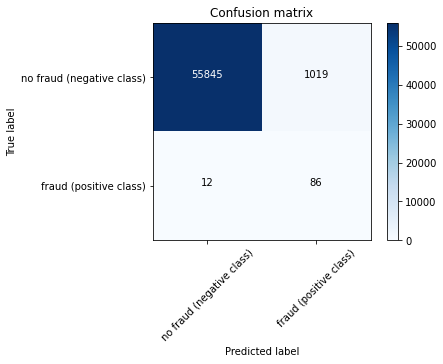

In [13]:
print(json.dumps(metrics, indent=4, sort_keys=True))
plot_confusion_matrix(cm, ['no fraud (negative class)', 'fraud (positive class)'])

In business terms, if the system classifies a fair transaction as fraud (false positive), the bank will investigate the issue probably using human intervention. According to a [2015 report from Javelin Strategy](https://www.javelinstrategy.com/press-release/false-positive-card-declines-push-consumers-abandon-issuers-and-merchants#), 15% of all cardholders have had at least one transaction incorrectly declined in the previous year, representing an annual decline amount of almost $118 billion. Nearly 4 in 10 declined cardholders report that they abandoned their card after being falsely declined.

However, if a fraudulent transaction is not detected, effectively meaning that the classifier predicts that a transaction is fair when it is really fraudulent (false negative), then the bank is losing money and the bad guy is getting away with it.  

A common way to use business rules in these predictions is to control the threshold or operation point of the prediction. This can be controlled changing the threshold value in `binarize_prediction(y_prob, threshold=0.5)`. It is common to do a loop from 0.1 to 0.9 and evaluate the different business outcomes.



In [14]:
clf.save_model(BASELINE_MODEL)

## O16N with Flask and Websockets

The next step is to operationalize (o16n) the machine learning model. For it, we are going to use [Flask](http://flask.pocoo.org/) to create a RESTfull API. The input of the API is going to be a transaction (defined by its features), and the output, the model prediction.

Aditionally, we designed a [websocket service](https://miguelgfierro.com/blog/2018/demystifying-websockets-for-real-time-web-communication/) to visualize fraudulent transactions on a map. The system works in real time using the library [flask-socketio](https://github.com/miguelgrinberg/Flask-SocketIO). 

When a new transaction is sent to the API, the LightGBM model predicts whether the transaction is fair or fraudulent. If the transaction is fraudulent, the server sends a signal to the a web client, that renders a world map showing the location of the fraudulent transaction. The map is made with javascript using [amCharts](http://amcharts.com/) and the map locations are taken from the previously created SQLite database.

To start the api execute `(fraud)$ python api.py` inside the conda environment. 

In [15]:
# You can also run the api from inside the notebook (even though I find it more difficult for debugging).
# To do it, just uncomment the next two lines:
#%%bash --bg --proc bg_proc
#python api.py

First, we make sure that the API is on

In [16]:
#server_name = 'http://the-name-of-your-server'
server_name = 'http://localhost'
root_url = '{}:{}'.format(server_name, PORT)
res = requests.get(root_url)
display(HTML(res.text))

Now, we are going to select one value and predict the output.

In [17]:
vals = y_test[y_test == 1].index.values
X_target = X_test.loc[vals[0]]
dict_query = X_target.to_dict()
print(dict_query)

{'Time': 57007.0, 'V1': -1.27124419171437, 'V2': 2.46267526851135, 'V3': -2.85139500331783, 'V4': 2.3244800653478, 'V5': -1.37224488981369, 'V6': -0.948195686538643, 'V7': -3.06523436172054, 'V8': 1.16692694787211, 'V9': -2.26877058844813, 'V10': -4.88114292689057, 'V11': 2.25514748870463, 'V12': -4.68638689759229, 'V13': 0.652374668512965, 'V14': -6.17428834800643, 'V15': 0.594379608016446, 'V16': -4.84969238709652, 'V17': -6.53652073527011, 'V18': -3.11909388163881, 'V19': 1.71549441975915, 'V20': 0.560478075726644, 'V21': 0.652941051330455, 'V22': 0.0819309763507574, 'V23': -0.221347831198339, 'V24': -0.523582159233306, 'V25': 0.224228161862968, 'V26': 0.756334522703558, 'V27': 0.632800477330469, 'V28': 0.250187092757197, 'Amount': 0.01}


In [18]:
headers = {'Content-type':'application/json'}
end_point = root_url + '/predict'
res = requests.post(end_point, data=json.dumps(dict_query), headers=headers)
print(res.ok)
print(json.dumps(res.json(), indent=2))


True
{
  "fraud": 1.0
}


### Fraudulent transaction visualization

Now that we know that the main end point of the API works, we will try the `/predict_map` end point. It creates a real time visualization system for fraudulent transactions using websockets. 

A websocket is a protocol intended for real-time communications developed for the HTML5 specification. It creates a persistent, low latency connection that can support transactions initiated by either the client or server. [In this post](https://miguelgfierro.com/blog/2018/demystifying-websockets-for-real-time-web-communication/) you can find a detailed explanation of websockets and other related technologies. 

<img src="static/img/websocket.svg?sanitize=true">

For our case, whenever a user makes a request to the end point `/predict_map`, the machine learning model evaluates the transaction details and makes a prediction. If the prediction is classified as fraudulent, the server sends a signal using `socketio.emit('map_update', location)`. This signal just contains a dictionary, called `location`, with a simulated name and location of where the fraudulent transaction occurred. The signal is shown in `index.html`, which just renders some javascript code that is referenced via an `id="chartdiv"`. 

The javascript code is defined in the file `frauddetection.js`. The websocket part is the following:
```js
var mapLocations = [];
// Location updated emitted by the server via websockets
socket.on("map_update", function (msg) {
    var message = "New event in " + msg.title + " (" + msg.latitude
        + "," + msg.longitude + ")";
    console.log(message);
    var newLocation = new Location(msg.title, msg.latitude, msg.longitude);
    mapLocations.push(newLocation);

    //clear the markers before redrawing
    mapLocations.forEach(function(location) {
      if (location.externalElement) {
        location.externalElement = undefined;
      }
    });

    map.dataProvider.images = mapLocations;
    map.validateData(); //call to redraw the map with new data
});
```
When a new signal is emited from the server in python, the javascript code receives it and processes it. It creates a new variable called `newLocation` containing the location information, that is going to be saved in a global array called `mapLocations`. This variable contains all the fradulent locations that appeared since the session started. Then there is a clearing process for amCharts to be able to draw the new information in the map and finally the array is stored in `map.dataProvider.images`, which actually refresh the map with the new point. The variable `map` is set earlier in the code and it is the amCharts object responsible for defining the map.

To make a query to the visualization end point:

In [19]:
headers = {'Content-type':'application/json'}
end_point_map = root_url + '/predict_map'
res = requests.post(end_point_map, data=json.dumps(dict_query), headers=headers)
print(res.text)

{
  "fraud": 1.0
}



Now you can go the map url (in local it would be http://localhost:5000/map) and see how the map is reshesed with a new fraudulent location every time you execute the previous cell. 
You should see a map like the following one:
[![map](./static/img/map.png)](https://youtu.be/KiCeeJAlgJU)

## Load test

Once we have the API, we can test its scalability and response time. 

Here you can find a simple load test to evaluate the performance of your API. Please bear in mind that, in this case, there is no request overhead due to the different locations of client and server, since the client and server are the same computer. 

The response time of 10 requests is around 300ms, so one request would be 30ms.

In [20]:
num = 10
concurrent = 2
verbose = True
payload_list = [dict_query]*num

In [21]:
%%time
with aiohttp.ClientSession() as session:  # We create a persistent connection
    loop = asyncio.get_event_loop()
    calc_routes = loop.run_until_complete(run_load_test(end_point, payload_list, session, concurrent, verbose))

ERROR:asyncio:Creating a client session outside of coroutine
client_session: <aiohttp.client.ClientSession object at 0x7f16847333c8>


Response status: 200
{'fraud': 7.284115783035928e-06}
Response status: 200
{'fraud': 7.284115783035928e-06}
Response status: 200
{'fraud': 7.284115783035928e-06}
Response status: 200
{'fraud': 7.284115783035928e-06}
Response status: 200
Response status: 200
{'fraud': 7.284115783035928e-06}
{'fraud': 7.284115783035928e-06}
Response status: 200
Response status: 200
{'fraud': 7.284115783035928e-06}
{'fraud': 7.284115783035928e-06}
Response status: 200
{'fraud': 7.284115783035928e-06}
Response status: 200
{'fraud': 7.284115783035928e-06}
CPU times: user 14.8 ms, sys: 15.8 ms, total: 30.6 ms
Wall time: 296 ms


In [ ]:
# If you run the API from the notebook, you can uncomment the following two lines to kill the process
#%%bash
#ps aux | grep 'api.py' | grep -v 'grep' | awk '{print $2}' | xargs kill

## Enterprise grade reference architecture for fraud detection

In this tutorial we have seen how to create a baseline fraud detection model. However, for a big company this is not enough. 

In the next figure we can see a reference architecture for fraud detection, that should be adapted to the customer specifics. All services are based on Azure.

1) Two general data sources for the customer: real time data and static information.

2) A general database piece to store the data. Since it is a reference architecture, and without more data, I put several options together ([SQL Database](https://azure.microsoft.com/en-gb/services/sql-database/), [CosmosDB](https://azure.microsoft.com/en-gb/services/cosmos-db/), [SQL Data Warehouse](https://azure.microsoft.com/en-gb/services/sql-data-warehouse/), etc) on cloud or on premise.

3) Model experimentation using [Azure ML](https://azure.microsoft.com/en-gb/overview/machine-learning/), again, using general computation targets such as [DSVM](https://azure.microsoft.com/en-gb/services/virtual-machines/data-science-virtual-machines/), [BatchAI](https://azure.microsoft.com/en-gb/services/batch-ai/), [Databricks](https://azure.microsoft.com/en-gb/services/databricks/) or [HDInsight](https://azure.microsoft.com/en-gb/services/hdinsight/).

4) Model retraining using new data and a model obtained from the [Model Management](https://docs.microsoft.com/en-gb/azure/machine-learning/desktop-workbench/model-management-overview).

5) Operationalization layer with a [Kubernetes cluster](https://azure.microsoft.com/en-gb/services/container-service/kubernetes/), which takes the best model and put it in production.

6) Reporting layer to show the results.

<img src="https://raw.githubusercontent.com/miguelgfierro/sciblog_support/master/Intro_to_Fraud_Detection/templates/fraud_detection_reference_architecture.svg?sanitize=true">